# 特徴量を選択する方法について #

## この記事の目的 ##
前回の記事では、irisの分類問題を解く一連の流れを書きましたが、今回はその中の次元削減に注目していきたいと思います。また、PCAとLDAによって次元削減した結果、分類精度がどうなるかを試してみました。

## PCAとLDAの違い(ざっくり) ##
1. PCAは分散が最大になる方向に

# 1. データ読み込み、データの前処理 #
ここではデータの読み込みからデータの分割までを行なっています。

In [1]:
from sklearn.datasets import load_iris
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df["target"] = iris_data.target

#学習用(&検証用)データとテスト用データを分ける
x_train, x_test, y_train, y_test = train_test_split(
    iris_df.iloc[:, 0:4],
    iris_df.iloc[:, 4],
    test_size = 0.3,
    random_state=1
)

#データの標準化
scl = StandardScaler()
scl.fit(x_train) #学習用データで標準化
x_train_std = scl.transform(x_train)
x_test_std = scl.transform(x_test)

# 2. PCA(主成分分析)とLDA(線形判別分析)による次元削減 #
### PCAによる次元削減 ###

In [2]:
from sklearn.decomposition import PCA
import numpy as np

pca=PCA()
pca.fit(x_train_std)
# display(pca.explained_variance_ratio_)
tot = sum(pca.explained_variance_ratio_)
print("寄与率:", str(["{:.1f}%".format(val * 100/tot)  for val in pca.explained_variance_ratio_]))

寄与率: ['72.2%', '23.5%', '4.0%', '0.4%']


寄与率をみると、上位２つで95%以上の寄与率となっているので、PCAでは２次元に縮小したいと思います。

In [3]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca.fit(x_train_std)
x_train_pca = pca.transform(x_train_std)

### LDA(Linear Discriminant Analysis)による次元削減 ###

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
 

ModuleNotFoundError: No module named 'sklearn.lda'

# 3. 主成分分析による特徴量の選択 #
読み込んだデータには４つの特徴量があります。特徴量が多いと学習効率が悪くなるので可能であれば使用する特徴量を減らします。そこでどの特徴量を使用するかを主成分分析で決めていきます。

主成分分析の詳細については他の記事([例えばこちら](https://logics-of-blue.com/principal-components-analysis/))を参考にしてください。ただ簡単に言いますと、データの分散が最大になる方向に軸を取り直すことを言います。

In [3]:
from sklearn.decomposition import PCA
import numpy as np

pca=PCA()
pca.fit(x_train_std)
# display(pca.explained_variance_ratio_)
tot = sum(pca.explained_variance_ratio_)
print("寄与率:", str(["{:.1f}%".format(val * 100/tot)  for val in pca.explained_variance_ratio_]))

寄与率: ['72.2%', '23.5%', '4.0%', '0.4%']


主成分分析を実行したら主成分軸のpc1とpc2の寄与率が高いことがわかります。そこで試しにpc1とpc2から成る２次元空間にデータを射影してみましょう。まずは変換後の次元が２次元になるように主成分分析を改めて実行した後にデータを射影したものを下に図示しました。

データをpc1, pc2に射影した図


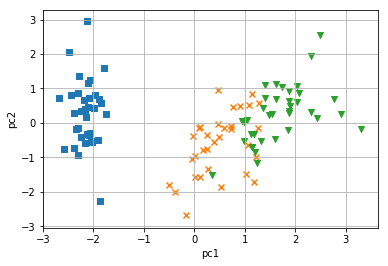

In [5]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca.fit(x_train_std)
x_train_pca = pca.transform(x_train_std)

def show_scatter(x, y):
    markers = ["s", "x", "v"]
    for idx, label in enumerate(np.unique(y)):
        plt.scatter(
            x=x[y == label, 0], 
            y=x[y == label, 1],
            marker = markers[idx],
            label = label
        )
    plt.grid()
    plt.xlabel("pc1")
    plt.ylabel("pc2")
    plt.show()

print("データをpc1, pc2に射影した図")
show_scatter(x_train_pca, y_train)

 上図を見るとpc1とpc2でうまく分類できそうな感じがしますね。では、このpc1とpc2はどの様な特徴量を表しているのかに関してですが、分散が最大になる方向に自動作成された軸(特徴量)であり意味があるものとは限りません。ではどの様にして主成分分析の結果から特徴量を選ぶかというと、元の特徴量をpc1, pc2の空間に射影してお互いに似ていない特徴量を選んで使用します。

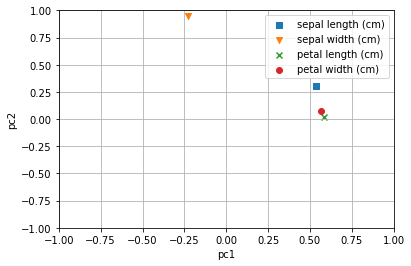

In [6]:
axis = np.array(
    [[1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]],
    np.float
)

axis_pca = pca.transform(axis)
markers = ["s", "v", "x", "o"]
for idx, val in enumerate(range(4)):
    plt.scatter(
        x = axis_pca[idx, 0], 
        y = axis_pca[idx, 1],
        marker = markers[idx],
        label = iris_df.columns[idx]
    )
plt.legend()
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()

上図は元の特徴ベクトルをpc1, pc2に射影したものです。図より"sepal width"以外の特徴量は近い位置に存在していて似た情報であることがわかります。よって、分類問題で使用する特徴量としては"sepal width"と"petal length"を使用することにします。

# 4. ロジステック回帰モデルの学習#
使用する特徴量が決まったので、ロジステック回帰モデルをデータに適用して分類してみたいと思います。また、精度をあげるためにグリッドサーチによるハイパーパラメータの調整を行いました。

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
params = {"C": [0.001, 1, 10 , 100, 1000]}
rg = LogisticRegression()
grid = GridSearchCV(
    estimator = rg,
    param_grid = params,
    cv = 5
)
grid.fit(x_train_std[:, [1, 2]], y_train)
print("{:.2f}%".format(grid.score(x_train_std[:, [1, 2]], y_train) * 100))

93.33%


ハイパーパラメータを調整した結果、学習データで93.3%の正解率となりました。良さそうなモデルです!!では、グリッドサーチによるパラメータの調整結果を見ると"C"の調整結果は"C"=100となっていることがわかります。"C"は正則化に関するパラメータでモデルの過学習を予防します。

In [8]:
print(grid.best_score_)
print(grid.best_params_)

0.9238095238095239
{'C': 1000}


# 5. モデルの評価 #
最後に作成したモデルの評価を行いたいと思います。様々な評価方法がありますが、今回はシンプルな正解率で評価したいと思います。正解率とはモデルが正しく予想したデータの割合のことです。ここで注意することは、モデルの学習に使用したデータを使って評価をしてはいけないということです。今回は、最初に用意した検証用データを用いて正解率を計算します。

In [9]:
from sklearn.metrics import accuracy_score
print( "正解率:{:.2f}%".format(accuracy_score(y_test, grid.predict(x_test_std[:, [1, 2]])) * 100 ))

正解率:95.56%


検証用データを使用した正解率は95.5%となかなかの結果が出ました。

# 6. まとめ #
以上が分類問題を機械学習で解く場合の基本的な流れです。今回紹介した流れは僕が勉強したことを僕の理解の範囲内でまとめたものにすぎません、よってもっと適切な方法があるはずです。でも、まあ入門としては及第点ですかね？今後さらに勉強して、いろいろなモデルや評価方法を試していきたいと思います。

# おまけ#
scikit-learnを使用しない主成分分析の方法をメモっておきます。

In [10]:
# scikit-learnを使用しないでPCAを実行する
import numpy as np

# 共分散行列
cov_mat = np.cov(x_train_std.T)
# 固有値と固有ベクトル
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
# 分散説明率(寄与率)
tot = sum(eigen_vals)
cont_rate = [val / tot for val in eigen_vals]
print(["{:.2f}".format(i) for i in cont_rate])

['0.72', '0.23', '0.04', '0.00']
